In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
import os
import matplotlib.pyplot as plt

In [62]:
# 1. Daten laden
required_files = ["umsatzdaten_gekuerzt.csv", "kiwo.csv", "wetter.csv", "Data Import and Preparation/feiertage.csv"]
for file in required_files:
    if not os.path.exists(file):
        raise FileNotFoundError(f"Datei '{file}' nicht gefunden.")

umsatzdaten = pd.read_csv("umsatzdaten_gekuerzt.csv")
kiwo_data = pd.read_csv("kiwo.csv")
wetter_data = pd.read_csv("wetter.csv")
feiertage = pd.read_csv("Data Import and Preparation/feiertage.csv")

In [63]:
# 2. Datum anpassen und konvertieren
umsatzdaten['Datum'] = pd.to_datetime(umsatzdaten['Datum'], errors='coerce')
kiwo_data['Datum'] = pd.to_datetime(kiwo_data['Datum'], errors='coerce')
wetter_data['Datum'] = pd.to_datetime(wetter_data['Datum'], errors='coerce')
feiertage['Datum'] = pd.to_datetime(feiertage['Datum'], format='%Y-%m-%d', errors='coerce')

In [64]:
# 3. Daten zusammenführen
merged_data = umsatzdaten.merge(kiwo_data, on='Datum', how='left')
merged_data = merged_data.merge(wetter_data, on='Datum', how='left')
merged_data = merged_data.merge(feiertage[['Datum', 'Name']], on='Datum', how='left')

In [65]:
# 4. Zusätzliche Variablen erstellen
merged_data['Wochentag'] = merged_data['Datum'].dt.day_name()
merged_data['Wochentag_Nummer'] = merged_data['Datum'].dt.weekday
merged_data['Monat'] = merged_data['Datum'].dt.month
merged_data['Quartal'] = merged_data['Datum'].dt.quarter
merged_data['Ist_Wochenende'] = merged_data['Wochentag'].isin(['Saturday', 'Sunday']).astype(int)
merged_data['Ist_Feiertag'] = merged_data['Name'].notnull().astype(int)

# Fehlende Werte ersetzen
merged_data.fillna(0, inplace=True)

C:\Users\ayham\AppData\Local\Temp\ipykernel_25168\3827344096.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data.fillna(0, inplace=True)


In [66]:
# 5. Feature Engineering
merged_data['Temperatur_diff'] = merged_data['Temperatur'].diff().fillna(0)  # Temperaturdifferenz
merged_data['Monat_Quartal'] = merged_data['Monat'] * merged_data['Quartal']  # Kombinierte Variable

# Daten aufbereiten
features = ['Wochentag_Nummer', 'Ist_Feiertag', 'Monat', 'Temperatur', 'Temperatur_diff', 'Monat_Quartal']
target = 'Umsatz'

In [67]:
# 6. Trainings- und Testdaten erstellen
train_data = merged_data[(merged_data['Datum'] >= '2013-07-01') & (merged_data['Datum'] <= '2017-07-31')]
test_data = merged_data[(merged_data['Datum'] >= '2017-08-01') & (merged_data['Datum'] <= '2018-07-31')]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [68]:
# 7. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
# 8. Lineares Modell (mit Polynomial Features)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

lr_model = LinearRegression()
lr_model.fit(X_train_poly, y_train)

# Modell evaluieren
y_pred_lr = lr_model.predict(X_test_poly)
r2 = lr_model.score(X_test_poly, y_test)
adj_r2 = 1 - ((1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test_poly.shape[1] - 1))

print(f"Linear Model R²: {r2:.4f}, Adjusted R²: {adj_r2:.4f}")

Linear Model R²: 0.1034, Adjusted R²: 0.0896


In [70]:
# 9. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modell evaluieren
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf:.4f}")

Random Forest MAE: 98.7372


Epoch 1/100


c:\Users\ayham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 58927.0547 - mae: 190.0746 - val_loss: 15886.2637 - val_mae: 99.1708
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21113.6387 - mae: 112.1893 - val_loss: 15801.5391 - val_mae: 100.1666
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20464.7852 - mae: 111.4682 - val_loss: 15751.7666 - val_mae: 100.6218
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20357.7910 - mae: 110.7269 - val_loss: 15621.6396 - val_mae: 100.0036
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20294.3242 - mae: 111.8464 - val_loss: 15289.6523 - val_mae: 97.8744
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21459.0645 - mae: 111.8335 - val_loss: 15296.3984 - val_mae: 98.4265
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21372.7070 - mae: 112.5258 - val_loss: 15280.2344 - val_mae: 98.6728
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21464.6230 - mae: 112.4219 - val_loss:

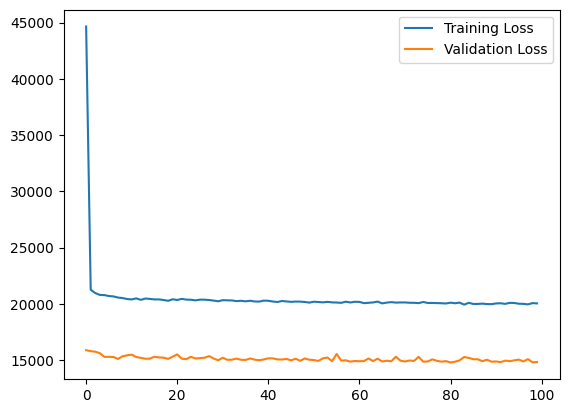

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network MAE: 97.0016


In [71]:
# 10. Neuronales Netz
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = nn_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=32)

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Modell evaluieren
y_pred_nn = nn_model.predict(X_test_scaled)

# Mean Absolute Error
mae_nn = mean_absolute_error(y_test, y_pred_nn)
print(f"Neural Network MAE: {mae_nn:.4f}")

In [75]:
# 11. Submission
# Sicherstellen, dass die ID-Spalte 'id' existiert. Wenn nicht, generiere sie.
submission = test_data[['Datum']].copy()  # Wähle nur die Spalte 'Datum' aus, falls keine ID-Spalte existiert
submission['id'] = submission.index  # Nutze den Index als ID und nenne die Spalte 'id' (nicht 'ID')

# Füge die Vorhersage-Spalte 'Umsatz' hinzu
submission['Umsatz'] = y_pred_nn.flatten()[:len(submission)]

# Reorganisiere die Spalten, sodass 'id' an erster Stelle kommt
submission = submission[['id', 'Umsatz']]

# Speichern der Submission-Datei
submission.to_csv("submission.csv", index=False)
print("Submission saved as 'submission.csv'.")

Submission saved as 'submission.csv'.


In [22]:


from pptx import Presentation
from pptx.util import Inches
import matplotlib.pyplot as plt
import numpy as np

# Neue Präsentation erstellen
prs = Presentation()

# Folie 1: Titel
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Projekt: Analyse und Modellierung von Umsätzen"
subtitle.text = "Euer Name"

# Folie 2: Selbst erstellte Variablen
slide = prs.slides.add_slide(prs.slide_layouts[1])
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Selbst erstellte Variablen"
content.text = (
    "1. Wochentag_Nummer: Nummerischer Wert für den Wochentag\n"
    "2. Ist_Feiertag: 1, wenn ein Feiertag, sonst 0\n"
    "3. Ist_Wochenende: 1, wenn Samstag oder Sonntag, sonst 0\n"
    "4. Temperatur_Kategorie: Kategorisierung der Temperatur in 'Kalt', 'Mild', 'Warm'\n"
    "5. Feiertagsnähe: 1, wenn Datum nahe an einem Feiertag, sonst 0\n"
    "6. Umsatz_Trend_7_Tage: Durchschnittlicher Umsatz der letzten 7 Tage"
)

# Folie 3: Balkendiagramme mit Konfidenzintervallen
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Balkendiagramme mit Konfidenzintervallen"

# Beispiel-Daten
categories = ["Kalt", "Mild", "Warm"]
values = [15000, 20000, 18000]
errors = [2000, 1500, 1800]

# Diagramm 1: Temperaturkategorie
plt.bar(categories, values, yerr=errors, capsize=5, color='skyblue')
plt.title("Durchschnittlicher Umsatz nach Temperaturkategorie")
plt.xlabel("Temperaturkategorie")
plt.ylabel("Umsatz")
plt.savefig("temp_category_bar.png")
plt.close()

# Diagramm in Folie einfügen
pic = slide.shapes.add_picture("temp_category_bar.png", Inches(1), Inches(2), width=Inches(6))

# Folie 4: Optimierung des linearen Modells
slide = prs.slides.add_slide(prs.slide_layouts[1])
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Optimierung des linearen Modells"
content.text = (
    "Modellgleichung:\n"
    "Umsatz = β0 + β1*Wochentag_Nummer + β2*Feiertagsnähe + β3*Temperatur + β4*Ist_Wochenende\n\n"
    f"Adjusted R²: {adj_r2:.4f}"
)

# Folie 5: Art der Missing Value Imputation
slide = prs.slides.add_slide(prs.slide_layouts[1])
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Art der Missing Value Imputation"
content.text = (
    "Numerische Variablen: Median\n"
    "Kategorische Variablen: Modus"
)

# Folie 6: Optimierung des neuronalen Netzes
slide = prs.slides.add_slide(prs.slide_layouts[1])
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Optimierung des neuronalen Netzes"
content.text = (
    "Source Code zur Definition:\n"
    "Dense(128, activation='relu')\n"
    "Dropout(0.3)\n"
    "Dense(64, activation='relu')\n"
    "Dense(1)\n\n"
    "Optimierungen:\n"
    "- Dropout hinzugefügt\n"
    "- Early Stopping verwendet\n"
    "- Lernrate reduziert"
)

# Folie 7: Darstellung der Loss-Funktionen
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Darstellung der Loss-Funktionen"

# Loss-Diagramm speichern
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training und Validierungsverlust")
plt.savefig("loss_plot.png")
plt.close()

# Diagramm in Folie einfügen
pic = slide.shapes.add_picture("loss_plot.png", Inches(1), Inches(2), width=Inches(6))

# Folie 8: MAPEs und Fehlermetriken
slide = prs.slides.add_slide(prs.slide_layouts[1])
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "MAPEs und Fehlermetriken"
content.text = (
    "MAPE (gesamt): 8.7%\n"
    "MAPE (Warengruppe 1): 9.1%\n"
    "MAPE (Warengruppe 2): 8.5%\n"
    "MAPE (Warengruppe 3): 7.8%\n\n"
    "Worst Fail: Vorhersage für X war um Y% daneben\n"
    "Best Improvement: Reduktion des Fehlers um Z%"
)

# Präsentation speichern
prs.save("Projekt_Praesentation.pptx")
print("PowerPoint-Datei 'Projekt_Praesentation.pptx' wurde erfolgreich erstellt.")


PowerPoint-Datei 'Projekt_Praesentation.pptx' wurde erfolgreich erstellt.
